# Easy Cash - Análise de Previsão de Inadimplência

INTRODUÇÃO

Na Sprint 02 será construido um modelo que possa predizer de acordo com os dados bancários de cada cliente, se essa pessoa pode ou não se tornar inadimplente

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (14,6))
%matplotlib inline


## Importando os dados para análise

In [2]:
dados = pd.read_csv('../Sprint01/dados/dados_unidos.csv')
dados.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


#### Renomeando Colunas

In [3]:
# Declarando dicionário para tradução das colunas (en -> pt)
dict_col_name = {
    'person_age': 'idade',
    'person_income': 'salario',
    'person_home_ownership': 'situacao_moradia',
    'person_emp_length': 'tempo_trabalho',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros',
    'loan_status': 'inadimplencia',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}

In [4]:
# Renomeando Colunas (Axis = 1 -> Coluna)
dados.rename(dict_col_name, axis= 1, inplace=True)
dados.head(5)

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,21.0,60000.0,Rent,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Mortgage,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Mortgage,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Rent,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Rent,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


#### Renomeando dados

In [5]:
# Declarando dicionário para tradução dos dados das colunas (en -> pt)
dict_situacao_moradia = {
    'Rent': 'Alugada',
    'Own': 'Propria',
    'Mortgage': 'Hipotecada',
    'Other': 'Outros'
}

dict_motivo_emprestimo = {
    'Personal':'Pessoal',
    'Education': 'Educativo',
    'Medical':'Medico',
    'Venture':'Empreendimento',
    'Homeimprovement': 'Melhoria do Lar',
    'Debtconsolidation': 'Pagamento de Debitos'
}

In [6]:
# Renomeando dados de tradução
dados.replace(dict_situacao_moradia, inplace=True)
dados.head(5)

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,21.0,60000.0,Alugada,2.0,Education,B,8000.0,11.26,0.0,0.13,N,3.0
1,40.0,70000.0,Hipotecada,6.0,Education,A,18000.0,7.90,0.0,0.26,N,14.0
2,29.0,115000.0,Hipotecada,3.0,Medical,C,22000.0,15.23,0.0,0.19,Y,7.0
3,26.0,84996.0,Alugada,0.0,Medical,B,9000.0,11.26,0.0,0.11,N,2.0
4,23.0,54500.0,Alugada,2.0,Debtconsolidation,A,8000.0,NaN,0.0,0.15,N,2.0


In [7]:
# Renomeando dados de tradução
dados.replace(dict_motivo_emprestimo, inplace=True)
dados['motivo_emprestimo'].unique()

array(['Educativo', 'Medico', 'Pagamento de Debitos', 'Pessoal',
       'Empreendimento', 'Melhoria do Lar', nan], dtype=object)

## Análise Exploratória

OBJETIVO

Explorar os dados e Identificar Dados Nulos, Valores Inconsistentes e Outliers

In [8]:
# Verificando a qtd de registros
print(f'Tamanho do Dataset: {dados.shape[0]}')

Tamanho do Dataset: 34501


In [9]:
# Verificando a taxa de inadimplentes
inadimplentes_perc = dados['devendo'].value_counts(normalize= True)
print(f'A Taxa de Pessoas com histórico de inadimplência é de: {(inadimplentes_perc[1] * 100).round(2)}%')

A Taxa de Pessoas com histórico de inadimplência é de: 17.59%


#### Dados Nulos

In [10]:
# Verificando os dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34501 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        34177 non-null  float64
 1   salario                      34162 non-null  float64
 2   situacao_moradia             34170 non-null  object 
 3   tempo_trabalho               33247 non-null  float64
 4   motivo_emprestimo            34186 non-null  object 
 5   pontuacao_emprestimo         34188 non-null  object 
 6   valor_emprestimo             34170 non-null  float64
 7   taxa_juros                   30871 non-null  float64
 8   inadimplencia                34158 non-null  float64
 9   renda_percentual_emprestimo  34182 non-null  float64
 10  devendo                      34131 non-null  object 
 11  tempo_de_credito             34497 non-null  float64
dtypes: float64(8), object(4)
memory usage: 3.2+ MB


- É possivel verificar a existência de dados nulos em todas os campos.

#### Inconsistência de Dados Categóricos

In [11]:
# Verificando os Dados Categoricos (Dados inconsistentes)
dados['situacao_moradia'].unique()

array(['Alugada', 'Hipotecada', 'Propria', 'Outros', nan], dtype=object)

In [12]:
dados['motivo_emprestimo'].unique()

array(['Educativo', 'Medico', 'Pagamento de Debitos', 'Pessoal',
       'Empreendimento', 'Melhoria do Lar', nan], dtype=object)

In [13]:
dados['pontuacao_emprestimo'].unique()

array(['B', 'A', 'C', 'D', 'E', 'F', nan, 'G'], dtype=object)

- Dados Categóricos sem inconsistência de dados e com valores nulos ('nan')
- Os campos de `situacao_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo` possuem mais de 2 categorias, portanto o procedimento de one hot encoding precisará ser realizado

#### Presença de Outliers

In [14]:
dados.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
idade,34177.0,27.731,6.345,20.00,23.00,26.00,30.00,144.00
salario,34162.0,66028.688,61405.058,4000.00,38493.00,55000.00,79200.00,6000000.00
tempo_trabalho,33247.0,4.787,4.137,0.00,2.00,4.00,7.00,123.00
valor_emprestimo,34170.0,9590.577,6320.429,500.00,5000.00,8000.00,12200.00,35000.00
taxa_juros,30871.0,11.014,3.241,5.42,7.90,10.99,13.47,23.22
inadimplencia,34158.0,0.218,0.413,0.00,0.00,0.00,0.00,1.00
renda_percentual_emprestimo,34182.0,0.170,0.107,0.00,0.09,0.15,0.23,0.83
tempo_de_credito,34497.0,5.808,4.063,2.00,3.00,4.00,8.00,30.00


- Identificado valores discrepantes através dos valores máx, dos seguintes campos: `idade`, `tempo_trabalho`, `salario`

<AxesSubplot: >

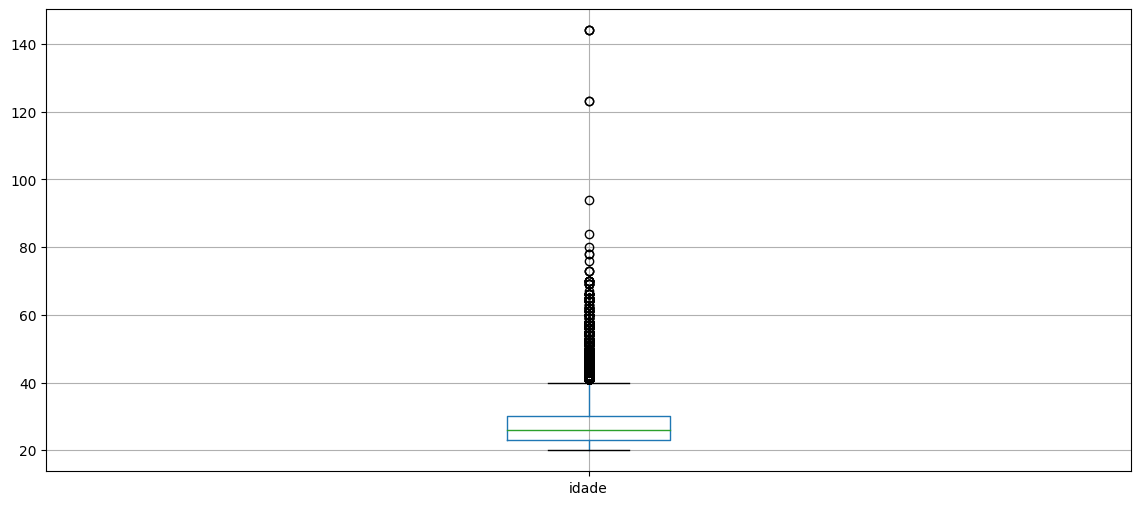

In [15]:
# Visualizando os dados de idade
dados.boxplot('idade')

<AxesSubplot: >

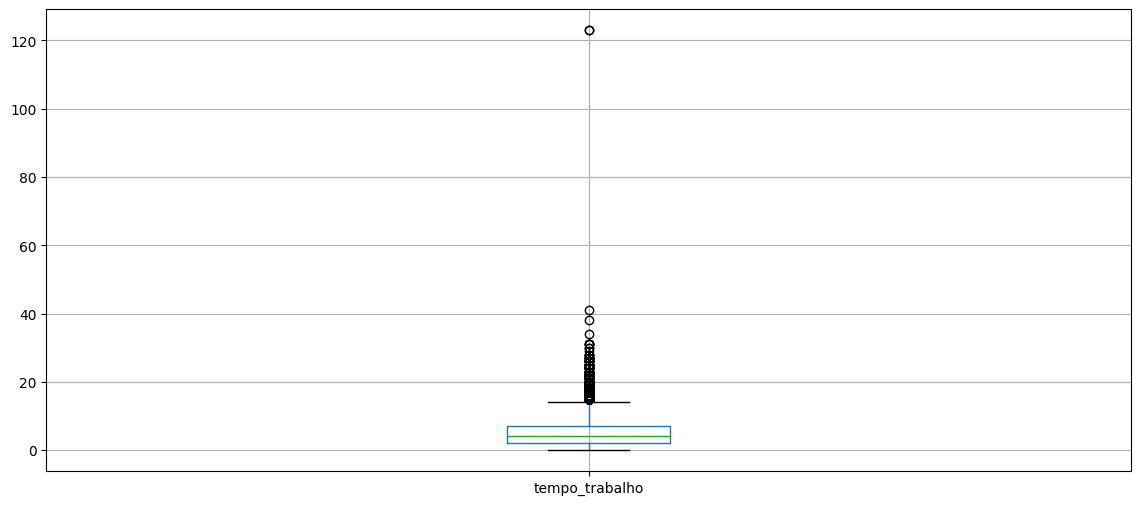

In [16]:
# Visualizando os dados de tempo de trabalho
dados.boxplot('tempo_trabalho')

<AxesSubplot: >

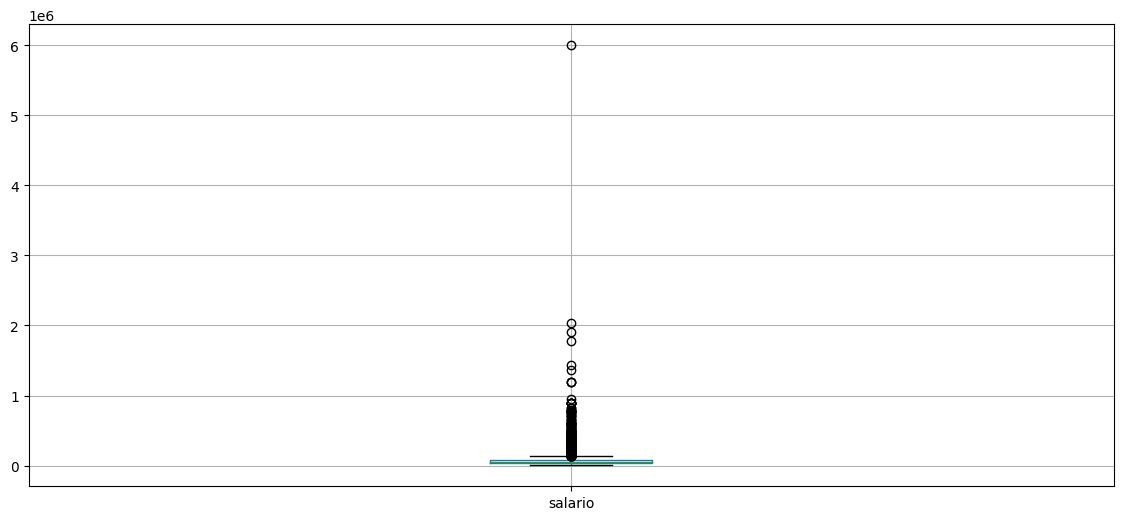

In [17]:
# Visualizando os dados de idade
dados.boxplot('salario')

## Limpeza dos Dados

Com base na análise feita anteriormente será iniciado a limpeza dos dados.

Será verificado  a quantidade de registros antes e após a limpeza de dados nulos para descobrir quantos dados serão perdidos no processo.

#### Remoção de Dados Nulos

In [18]:
# Verificando a qtd de valores nulos
print(f'Qtd de Dados Nulos:\n{dados.isnull().sum()}')

Qtd de Dados Nulos:
idade                           324
salario                         339
situacao_moradia                331
tempo_trabalho                 1254
motivo_emprestimo               315
pontuacao_emprestimo            313
valor_emprestimo                331
taxa_juros                     3630
inadimplencia                   343
renda_percentual_emprestimo     319
devendo                         370
tempo_de_credito                  4
dtype: int64


In [19]:
# Remoção de todos dados nulos
a = dados.shape[0]
dados_tratados = dados.dropna()
b = dados_tratados.shape[0]
print(f'Foram removidos {a-b}, Total de Registros Atual: {b}')

Foram removidos 5863, Total de Registros Atual: 28638


In [20]:
# Checkando se há valores Nulos - OK
dados_tratados.isnull().sum()

idade                          0
salario                        0
situacao_moradia               0
tempo_trabalho                 0
motivo_emprestimo              0
pontuacao_emprestimo           0
valor_emprestimo               0
taxa_juros                     0
inadimplencia                  0
renda_percentual_emprestimo    0
devendo                        0
tempo_de_credito               0
dtype: int64

#### Remoção de Outliers

Um dado é considerado outlier se:

- Dados < Q1 - 1.5 * IQR (limite inferior)
- Dados > Q3 + 1.5 * IQR (limite superior)

Para cálculo do IIQ, considere: IIQ = Q3 - Q1

 Será removido os outliers identificados nas colunas de : `idade`, `tempo_trabalho`, `salario`

In [21]:
# Calculando os limites para identificação dos outliers
iqr_idade = iqr(dados_tratados['idade'])
li = np.quantile(dados_tratados['idade'], 0.25) - 1.5 * iqr_idade
ls = np.quantile(dados_tratados['idade'], 0.75) + 1.5 * iqr_idade

In [22]:
# Realizando um Subset dos dados sem os outliers
a = dados_tratados.shape[0]
dados_tratados = dados_tratados[(dados_tratados['idade'] > li) & (dados_tratados['idade'] < ls)]
b = dados_tratados.shape[0]
print(f'Foram removidos {a-b}, Total de Registros Atual: {b}')

Foram removidos 1298, Total de Registros Atual: 27340


<AxesSubplot: >

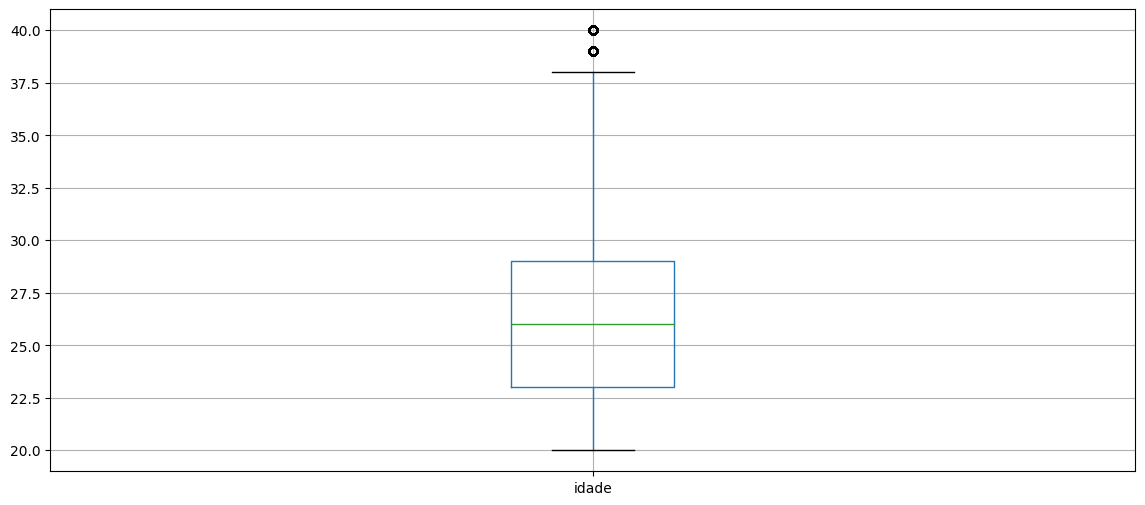

In [23]:
dados_tratados.boxplot('idade')

In [24]:
# Calculando os limites para identificação dos outliers
iqr_tempo_trabalho = iqr(dados_tratados['tempo_trabalho'])
li = np.quantile(dados_tratados['tempo_trabalho'], 0.25) - 1.5 * iqr_tempo_trabalho
ls = np.quantile(dados_tratados['tempo_trabalho'], 0.75) + 1.5 * iqr_tempo_trabalho

In [25]:
# Realizando um Subset dos dados sem os outliers
a = dados_tratados.shape[0]
dados_tratados = dados_tratados[(dados_tratados['tempo_trabalho'] > li) & (dados_tratados['tempo_trabalho'] < ls)]
b = dados_tratados.shape[0]
print(f'Foram removidos {a-b}, Total de Registros Atual: {b}')

Foram removidos 629, Total de Registros Atual: 26711


<AxesSubplot: >

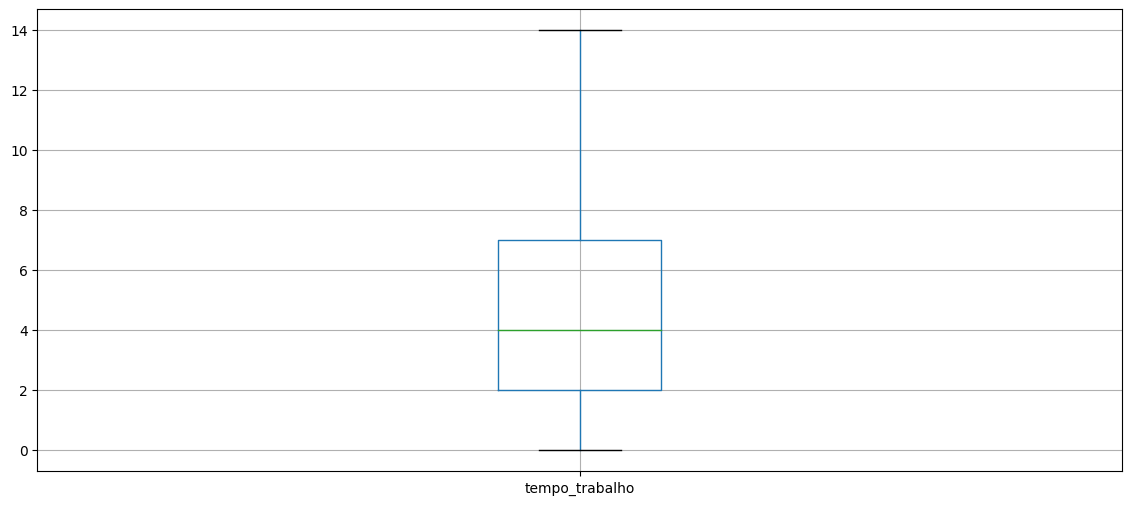

In [26]:
dados_tratados.boxplot('tempo_trabalho')

In [27]:
# Calculando os limites para identificação dos outliers
iqr_salario = iqr(dados_tratados['salario'])
li = np.quantile(dados_tratados['salario'], 0.25) - 1.5 * iqr_salario
ls = np.quantile(dados_tratados['salario'], 0.75) + 1.5 * iqr_salario

In [28]:
# Realizando um Subset dos dados sem os outliers
a = dados_tratados.shape[0]
dados_tratados = dados_tratados[(dados_tratados['salario'] > li) & (dados_tratados['salario'] < ls)]
b = dados_tratados.shape[0]
print(f'Foram removidos {a-b}, Total de Registros Atual: {b}')

Foram removidos 1297, Total de Registros Atual: 25414


<AxesSubplot: >

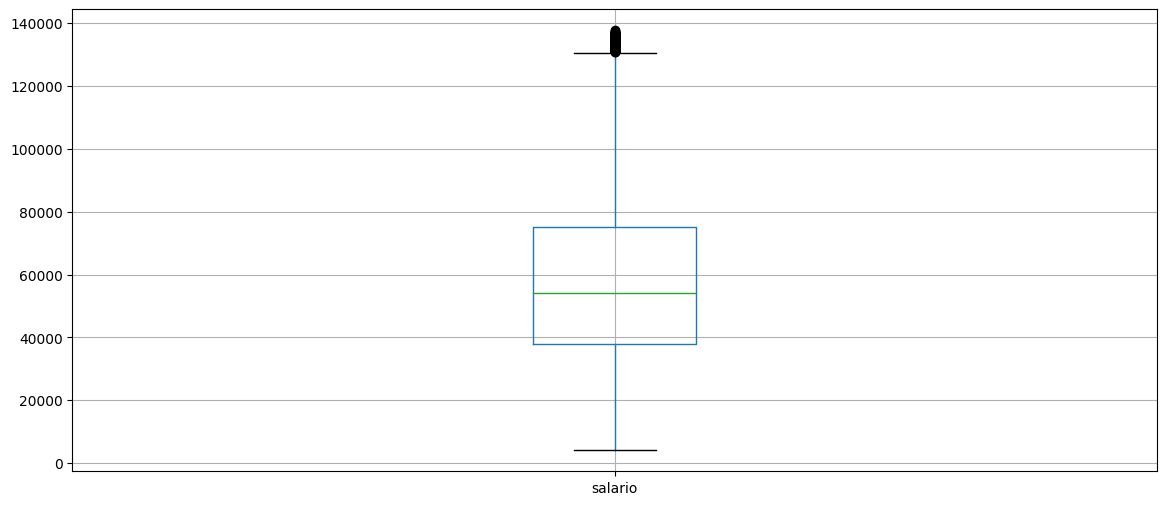

In [29]:
#verificando os dados
dados_tratados.boxplot('salario')

#### Alteração do dtype 

In [30]:
# Alteração do Dtype do tipo float64 para int64
dados_tratados['tempo_trabalho'] = dados_tratados['tempo_trabalho'].astype('int64')

In [31]:
# Verificando a taxa de inadimplentes após tratamento dos dados
inadimplentes_perc = dados_tratados['devendo'].value_counts(normalize= True)
print(f'A Taxa de Pessoas com histórico de inadimplência é de: {(inadimplentes_perc[1] * 100).round(2)}%')

A Taxa de Pessoas com histórico de inadimplência é de: 17.83%


## Preparação dos Dados

Agora se inicia o processo de tratamento de dados para que possam ser usados na etapa de modelagem.

As variáveis categóricas serão transformadas em variáveis dummy e as variáveis serão normalizadas para ficarem em uma mesma escala para que variáveis com escalas maiores não tenham peso maior que as outras.

In [32]:
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25414 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        25414 non-null  float64
 1   salario                      25414 non-null  float64
 2   situacao_moradia             25414 non-null  object 
 3   tempo_trabalho               25414 non-null  int64  
 4   motivo_emprestimo            25414 non-null  object 
 5   pontuacao_emprestimo         25414 non-null  object 
 6   valor_emprestimo             25414 non-null  float64
 7   taxa_juros                   25414 non-null  float64
 8   inadimplencia                25414 non-null  float64
 9   renda_percentual_emprestimo  25414 non-null  float64
 10  devendo                      25414 non-null  object 
 11  tempo_de_credito             25414 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 2.5+ MB


#### Teste de Correlação das Variáveis

Vamos extrair a correlação entre as variáveis numéricas para entender se há alguma relação direta ou indireta entre as variáveis.

In [33]:
dados_tratados.corr()

C:\Users\reyna\AppData\Local\Temp\ipykernel_49980\1634470880.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dados_tratados.corr()


,idade,salario,tempo_trabalho,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
idade,1.000000,0.080606,0.066496,0.034677,0.016314,-0.022832,-0.021279,0.829873
salario,0.080606,1.000000,0.197991,0.383939,-0.042812,-0.253973,-0.322658,0.048762
tempo_trabalho,0.066496,0.197991,1.000000,0.102595,-0.065028,-0.090860,-0.047487,0.054349
valor_emprestimo,0.034677,0.383939,0.102595,1.000000,0.133517,0.128286,0.650942,0.023705
taxa_juros,0.016314,-0.042812,-0.065028,0.133517,1.000000,0.337997,0.128787,0.020267
inadimplencia,-0.022832,-0.253973,-0.090860,0.128286,0.337997,1.000000,0.381395,-0.014168
renda_percentual_emprestimo,-0.021279,-0.322658,-0.047487,0.650942,0.128787,0.381395,1.000000,-0.008188
tempo_de_credito,0.829873,0.048762,0.054349,0.023705,0.020267,-0.014168,-0.008188,1.000000


Nota-se que a variável `renda_percentual_emprestimo` tem uma correlação alta de aproximadamente 0.65 com `valor_emprestimo` e de fato essa variável é construída utilizando o salário e o valor do empréstimo solicitado pelo cliente.

In [34]:
# Por isso iremos remover a coluna renda_percentual_emprestimo, para não haver informação duplicada no conjunto de dados.
dados2 = dados_tratados.drop('renda_percentual_emprestimo', axis=1)
dados2.head()

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,devendo,tempo_de_credito
0,21.0,60000.0,Alugada,2,Educativo,B,8000.0,11.26,0.0,N,3.0
1,40.0,70000.0,Hipotecada,6,Educativo,A,18000.0,7.90,0.0,N,14.0
2,29.0,115000.0,Hipotecada,3,Medico,C,22000.0,15.23,0.0,Y,7.0
3,26.0,84996.0,Alugada,0,Medico,B,9000.0,11.26,0.0,N,2.0
6,23.0,24000.0,Propria,7,Educativo,A,5000.0,7.49,0.0,N,2.0


#### Aplicação de Label Enconding (2 classes)
Para o processo de transformação das variáveis categóricas para dummys, é preciso substituir os valores da coluna devendo para 0 e 1, uma vez que essa variável possui apenas 2 classes

In [35]:
# Declarando dicionário para substituição dos valores
dict_devendo = {
    'N':'0',
    'Y': '1'
}

In [36]:
# Renomeando dados 
dados2.replace(dict_devendo, inplace=True)

### Separação dos dataframes de Variaveis Dependentes (Y) e Independentes (X)

In [37]:
# Removendo a Variável Dependente (alvo) 
x = dados2.drop('inadimplencia', axis=1)
x.head()

,idade,salario,situacao_moradia,tempo_trabalho,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,devendo,tempo_de_credito
0,21.0,60000.0,Alugada,2,Educativo,B,8000.0,11.26,0,3.0
1,40.0,70000.0,Hipotecada,6,Educativo,A,18000.0,7.90,0,14.0
2,29.0,115000.0,Hipotecada,3,Medico,C,22000.0,15.23,1,7.0
3,26.0,84996.0,Alugada,0,Medico,B,9000.0,11.26,0,2.0
6,23.0,24000.0,Propria,7,Educativo,A,5000.0,7.49,0,2.0


In [38]:
# Separando a Variável Dependente (y)
alvo = dados2['inadimplencia']
alvo.head(5)

0    0.0
1    0.0
2    0.0
3    0.0
6    0.0
Name: inadimplencia, dtype: float64

### Aplicação de One Hot Coding  (n classes)

As variáveis categóricas com mais de 2 categorias precisam passar por um processo de construção de novas colunas. Cada uma das novas colunas corresponde a uma das categorias e o valor será 1 caso o registro tenha a presença da característica e 0 caso contrário

Faremos a criação dessas novas colunas com o OneHotEncoder.

In [39]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [40]:
colunas_categoricas = ['situacao_moradia','motivo_emprestimo','pontuacao_emprestimo']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(), colunas_categoricas),
    remainder='passthrough')

dados_transformados = one_hot_enc.fit_transform(x)
dados_transformados = pd.DataFrame(dados_transformados, columns=one_hot_enc.get_feature_names_out())
dados_transformados.head()

,onehotencoder__situacao_moradia_Alugada,onehotencoder__situacao_moradia_Hipotecada,onehotencoder__situacao_moradia_Outros,onehotencoder__situacao_moradia_Propria,onehotencoder__motivo_emprestimo_Educativo,onehotencoder__motivo_emprestimo_Empreendimento,onehotencoder__motivo_emprestimo_Medico,onehotencoder__motivo_emprestimo_Melhoria do Lar,onehotencoder__motivo_emprestimo_Pagamento de Debitos,onehotencoder__motivo_emprestimo_Pessoal,...,onehotencoder__pontuacao_emprestimo_E,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__devendo,remainder__tempo_de_credito
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.0,60000.0,2,8000.0,11.26,0,3.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40.0,70000.0,6,18000.0,7.9,0,14.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,29.0,115000.0,3,22000.0,15.23,1,7.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,84996.0,0,9000.0,11.26,0,2.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,23.0,24000.0,7,5000.0,7.49,0,2.0
